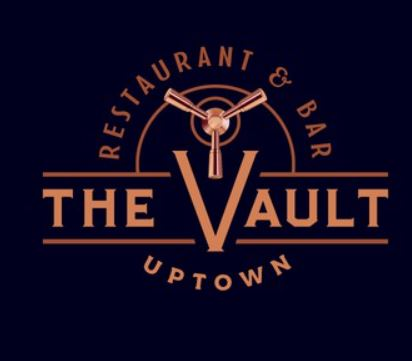

<div>
<img src="attachment:Vault_res.PNG" width="400">
<div>

In [1]:
%%javascript
/** Below because this notebook is pretty large */
var rto = 200;
console.log('NB: Increase require timeout to ' + rto + ' seconds');
window.requirejs.config({waitSeconds: rto});

<IPython.core.display.Javascript object>

In [2]:
SEMILLA = 99

In [3]:
CLASIFICADOR = 'LGBM'
N_ITERACIONES = 50


![Vault_res.JPG](attachment:Vault_res.JPG)

## Importacion de Librerías y Configuración de Consola

In [4]:
import imblearn
from imblearn.pipeline import Pipeline

import time 
import os
import janitor
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, dump

import joblib


from scipy import stats
# import feature_engine

import lightgbm as lgb

In [5]:
# Especificamos el directorio base, retrocediendo una carpeta
BASE = Path('..')
# Y, a partir de allí, definimos las carpetas que debieran existir
RAW = BASE/'raw'
NOTEBOOKS = BASE/'notebooks'
DATA = BASE/'data'
REFERENCIAS = BASE/'referencias'
PERFORMANCE = BASE/'performance'
MODELOS = BASE/'modelos'

In [6]:
# Creamos todos los directorios que definimos previamente, si no existieran aún.
path_list = [RAW, NOTEBOOKS, DATA, REFERENCIAS, PERFORMANCE, MODELOS]
for path_i in path_list:
    if not os.path.exists(path_i):
        os.makedirs(path_i)

In [7]:
#Tomo el tiempo al inicio de la ejecucion
start_time=time.time()

In [8]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.9f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [9]:
# Codigo para poder imprimir multiples outputs en una misma línea
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
# Definiremos el directorio en el que estamos trabajando. 
scripts=os.getcwd()  #Obtenemos la direccion actual
os.chdir('..') # Nos vamos una carpeta atrás
raiz=os.getcwd() # Esta direccion la guardaremos como "raiz" 
os.chdir(raiz+'\\raw') 
raw=os.getcwd()
os.chdir(raiz+'\\raw')
outputs=os.getcwd()

In [11]:
from datetime import date
today = date.today()
Today_Date = str(today)

# Importacion de Archivos

In [12]:
# Lee file de acciones argentinas
dict_acciones_arg = np.load(DATA/'mi_dict_acciones_arg.npy',allow_pickle='TRUE').item()

In [13]:
dict_acciones_arg['ggal'].tail(2)

,date,volume,high,low,merv_close,merv_open,merv_high,open,close,merv_low,ratio_ho,ratio_lo,ratio_co,ratio_hc,ratio_lc,ratio_hl,ratio_o_mean,ratio_c_mean,ratio_l_mean,ratio_h_mean,ratio_o_meanc,ratio_c_meanc,ratio_l_meanc,ratio_h_meanc,var_orig_high_vs_1,var_orig_high_vs_2,var_orig_high_vs_5,var_orig_ratio_c_meanc_vs_1,var_orig_ratio_c_meanc_vs_2,var_orig_ratio_c_meanc_vs_5,var_orig_merv_close_vs_1,var_orig_merv_close_vs_2,var_orig_merv_close_vs_5,var_orig_merv_open_vs_1,var_orig_merv_open_vs_2,var_orig_merv_open_vs_5,var_orig_open_vs_1,var_orig_open_vs_2,var_orig_open_vs_5,var_orig_ratio_h_mean_vs_1,var_orig_ratio_h_mean_vs_2,var_orig_ratio_h_mean_vs_5,var_orig_ratio_hl_vs_1,var_orig_ratio_hl_vs_2,var_orig_ratio_hl_vs_5,var_orig_ratio_l_meanc_vs_1,var_orig_ratio_l_meanc_vs_2,var_orig_ratio_l_meanc_vs_5,var_orig_ratio_co_vs_1,var_orig_ratio_co_vs_2,var_orig_ratio_co_vs_5,var_orig_merv_low_vs_1,var_orig_merv_low_vs_2,var_orig_merv_low_vs_5,var_orig_ratio_o_mean_vs_1,var_orig_ratio_o_mean_vs_2,var_orig_ratio_o_mean_vs_5,var_orig_ratio_l_mean_vs_1,var_orig_ratio_l_mean_vs_2,var_orig_ratio_l_mean_vs_5,var_orig_ratio_o_meanc_vs_1,var_orig_ratio_o_meanc_vs_2,var_orig_ratio_o_meanc_vs_5,var_orig_ratio_ho_vs_1,var_orig_ratio_ho_vs_2,var_orig_ratio_ho_vs_5,var_orig_volume_vs_1,var_orig_volume_vs_2,var_orig_volume_vs_5,var_orig_low_vs_1,var_orig_low_vs_2,var_orig_low_vs_5,var_orig_merv_high_vs_1,var_orig_merv_high_vs_2,var_orig_merv_high_vs_5,var_orig_ratio_lc_vs_1,var_orig_ratio_lc_vs_2,var_orig_ratio_lc_vs_5,var_orig_close_vs_1,var_orig_close_vs_2,var_orig_close_vs_5,var_orig_ratio_lo_vs_1,var_orig_ratio_lo_vs_2,var_orig_ratio_lo_vs_5,var_orig_ratio_c_mean_vs_1,var_orig_ratio_c_mean_vs_2,var_orig_ratio_c_mean_vs_5,var_orig_ratio_h_meanc_vs_1,var_orig_ratio_h_meanc_vs_2,var_orig_ratio_h_meanc_vs_5,var_orig_ratio_hc_vs_1,var_orig_ratio_hc_vs_2,var_orig_ratio_hc_vs_5,var_means_ratio_hc_m5d_m10d,var_means_ratio_hc_m5d_m12d,var_means_ratio_hc_m5d_m26d,var_means_ratio_hc_m5d_m120d,var_means_ratio_hc_m5d_m252d,var_means_ratio_hc_m10d_m12d,var_means_ratio_hc_m10d_m26d,var_means_ratio_hc_m10d_m120d,var_means_ratio_hc_m10d_m252d,var_means_ratio_hc_m12d_m26d,var_means_ratio_hc_m12d_m120d,var_means_ratio_hc_m12d_m252d,var_means_ratio_hc_m26d_m120d,var_means_ratio_hc_m26d_m252d,var_means_ratio_hc_m120d_m252d,vd_1d,vd_5d,vd_10d,vd_22d
4744,2021-02-02,1310376,0.797385621,0.774509804,324.750510621,324.031964869,330.802670547,0.784313725,0.779084947,324.031964869,1.016666667,0.987500000,0.993333308,1.023489959,0.994127542,1.029535865,0.582897957,0.579011956,0.575611733,0.592612923,0.607764042,0.603712267,0.600166992,0.617893443,0.022631994,0.012868436,0.046191382,0.000419601,0.030250649,0.031725370,0.002217515,0.029626445,0.024204344,0.027348284,-0.001071915,0.064862610,0.033591745,-0.003735965,0.088549284,0.022631994,0.012868436,0.046191382,0.001920447,-0.016620113,-0.026746583,0.020671848,0.029986935,0.074942418,-0.032094049,0.034114063,-0.052201507,0.027348284,0.028505181,0.064862610,0.033591745,-0.003735965,0.088549284,0.020671848,0.029986935,0.074942418,0.033591745,-0.003735965,0.088549284,-0.010603559,0.016666667,-0.038912250,0.497820782,-0.155156451,0.126626584,0.020671848,0.029986935,0.074942418,0.016856015,0.012257595,0.041437483,0.020243753,-0.000255971,0.041888131,0.000419601,0.030250649,0.031725370,-0.012500000,0.033849360,-0.012500000,0.000419601,0.030250649,0.031725370,0.022631994,0.012868436,0.046191382,0.022203077,-0.016871829,0.014021184,-0.001728102,-0.002790788,-0.001069599,-0.006630978,-0.010508640,-0.001064526,0.000659642,-0.004911363,-0.008795739,0.001726006,-0.003850937,-0.007739451,-0.005567333,-0.009449148,-0.003903547,0,0,0,0
4745,2021-02-03,1047763,0.793464062,0.772549000,325.866344975,324.750510621,329.267769608,0.778104595,0.773529402,324.658752042,1.019739592,0.992860092,0.994120079,1.025771044,0.998732560,1.027072797,0.578283363,0.574883103,0.574154473,0.589698441,0.602952593,0.599407279,0.598647566,0.614854631,-0.0049180

# Split Train & Test

In [14]:
ggal = dict_acciones_arg['ggal'].copy()

In [15]:
list_vds = [x for x in ggal.columns.tolist() if 'vd' in x]
list_vds

['vd_1d', 'vd_5d', 'vd_10d', 'vd_22d']

In [16]:
ggal

,date,volume,high,low,merv_close,merv_open,merv_high,open,close,merv_low,ratio_ho,ratio_lo,ratio_co,ratio_hc,ratio_lc,ratio_hl,ratio_o_mean,ratio_c_mean,ratio_l_mean,ratio_h_mean,ratio_o_meanc,ratio_c_meanc,ratio_l_meanc,ratio_h_meanc,var_orig_high_vs_1,var_orig_high_vs_2,var_orig_high_vs_5,var_orig_ratio_c_meanc_vs_1,var_orig_ratio_c_meanc_vs_2,var_orig_ratio_c_meanc_vs_5,var_orig_merv_close_vs_1,var_orig_merv_close_vs_2,var_orig_merv_close_vs_5,var_orig_merv_open_vs_1,var_orig_merv_open_vs_2,var_orig_merv_open_vs_5,var_orig_open_vs_1,var_orig_open_vs_2,var_orig_open_vs_5,var_orig_ratio_h_mean_vs_1,var_orig_ratio_h_mean_vs_2,var_orig_ratio_h_mean_vs_5,var_orig_ratio_hl_vs_1,var_orig_ratio_hl_vs_2,var_orig_ratio_hl_vs_5,var_orig_ratio_l_meanc_vs_1,var_orig_ratio_l_meanc_vs_2,var_orig_ratio_l_meanc_vs_5,var_orig_ratio_co_vs_1,var_orig_ratio_co_vs_2,var_orig_ratio_co_vs_5,var_orig_merv_low_vs_1,var_orig_merv_low_vs_2,var_orig_merv_low_vs_5,var_orig_ratio_o_mean_vs_1,var_orig_ratio_o_mean_vs_2,var_orig_ratio_o_mean_vs_5,var_orig_ratio_l_mean_vs_1,var_orig_ratio_l_mean_vs_2,var_orig_ratio_l_mean_vs_5,var_orig_ratio_o_meanc_vs_1,var_orig_ratio_o_meanc_vs_2,var_orig_ratio_o_meanc_vs_5,var_orig_ratio_ho_vs_1,var_orig_ratio_ho_vs_2,var_orig_ratio_ho_vs_5,var_orig_volume_vs_1,var_orig_volume_vs_2,var_orig_volume_vs_5,var_orig_low_vs_1,var_orig_low_vs_2,var_orig_low_vs_5,var_orig_merv_high_vs_1,var_orig_merv_high_vs_2,var_orig_merv_high_vs_5,var_orig_ratio_lc_vs_1,var_orig_ratio_lc_vs_2,var_orig_ratio_lc_vs_5,var_orig_close_vs_1,var_orig_close_vs_2,var_orig_close_vs_5,var_orig_ratio_lo_vs_1,var_orig_ratio_lo_vs_2,var_orig_ratio_lo_vs_5,var_orig_ratio_c_mean_vs_1,var_orig_ratio_c_mean_vs_2,var_orig_ratio_c_mean_vs_5,var_orig_ratio_h_meanc_vs_1,var_orig_ratio_h_meanc_vs_2,var_orig_ratio_h_meanc_vs_5,var_orig_ratio_hc_vs_1,var_orig_ratio_hc_vs_2,var_orig_ratio_hc_vs_5,var_means_ratio_hc_m5d_m10d,var_means_ratio_hc_m5d_m12d,var_means_ratio_hc_m5d_m26d,var_means_ratio_hc_m5d_m120d,var_means_ratio_hc_m5d_m252d,var_means_ratio_hc_m10d_m12d,var_means_ratio_hc_m10d_m26d,var_means_ratio_hc_m10d_m120d,var_means_ratio_hc_m10d_m252d,var_means_ratio_hc_m12d_m26d,var_means_ratio_hc_m12d_m120d,var_means_ratio_hc_m12d_m252d,var_means_ratio_hc_m26d_m120d,var_means_ratio_hc_m26d_m252d,var_means_ratio_hc_m120d_m252d,vd_1d,vd_5d,vd_10d,vd_22d
2040,2010-01-04,1485340,0.569948199,0.559585514,617.743520786,603.577735387,620.108838650,0.564766857,0.543521599,603.577735387,1.009174303,0.990825697,0.962382252,1.048621066,1.029555247,1.018518500,0.419731845,0.403942478,0.415881098,0.423582592,0.437637360,0.421174428,0.433622342,0.441652377,0.006864982,0.013824871,0.062427740,0.006928423,0.013953522,0.073616128,0.013550909,0.027474118,0.048225536,0.002931579,0.005880397,0.033029294,0.006928400,0.013953474,0.057904771,0.006864982,0.013824871,0.062427740,-0.002457888,-0.004949757,-0.001258540,0.009345841,0.018868020,0.063766533,0.000000023,0.000000047,0.014851391,0.005255392,0.010566314,0.033621242,0.006928400,0.013953474,0.057904771,0.009345841,0.018868020,0.063766533,0.006928400,0.013953474,0.057904771,-0.000062981,-0.000126834,0.004275403,inf,0.412978543,0.030992810,0.009345841,0.018868020,0.063766533,0.013867758,0.028125554,0.050246907,0.002400785,0.004846868,-0.009174225,0.006928423,0.013953522,0.073616128,0.002400808,0.004846914,0.005540916,0.006928423,0.013953522,0.073616128,0.006864982,0.013824871,0.062427740,-0.000063005,-0.000126880,-0.010421218,0.000296576,-0.000447137,-0.001902745,-0.004416376,-0.025400220,-0.000743493,-0.002198670,-0.004711555,-0.025689177,-0.001456259,-0.003971014,-0.024964245,-0.002518423,-0.023542270,-0.021076927,1,1,1,1
2041,2010-01-05,2624534,0.588082897,0.564766857,622.215025907,617.849715633,624.715000607,0.564766857,0.558480945,617.849715633,1.041284363,1.000000000,0.988869899,1.053004408,1.011255374,1.041284363,0.419731845,0.415060187,0.419731845,0.437060207,0.437637360,0.432766412,0.437637360,0.455704939,0.031818151,0.038901564

In [17]:
# Split temporal entre train y test
df_train = ggal[(ggal['date']>='2010-01-01')&(ggal['date']<'2018-01-01')].set_index(['date'])
df_test  = ggal[ggal['date']>'2018-01-01'].set_index(['date'])

# Separamos la X (atributos) y las múltiples y 
X_train, X_test = df_train.drop(columns=list_vds) , df_test.drop(columns=list_vds)

y_train_dict = {}
y_test_dict = {}
# en el dictionary guardaremos los distintos dataframes, en cada uno una vd distinta
for vd_i in list_vds:
    y_train_dict[vd_i] = df_train[vd_i]
    y_test_dict[vd_i]  = df_test[vd_i]

In [18]:
list_vds[0]

'vd_1d'

In [19]:
X_train_prepnres = X_train.copy()
X_val_prep = X_test.copy()
y_train_prepnres = y_train_dict[list_vds[0]].copy()
y_val = y_test_dict[list_vds[0]].copy()

In [20]:
# Aquí, si tuvieramos pipeline de preprocesamiento deberíamos:
# preprocesar el X_Train, y luego resamplearlo (tanto a X_train como a y_train)
# y al x_validacion solo preprocesarlo 

# Modelado

## Importamos modelo a utilizar

In [32]:
clf_fitted = joblib.load(MODELOS/f"HPS_clf_fitted_ggal_{CLASIFICADOR}.joblib")
clf_fitted

LGBMClassifier(colsample_bytree=0.7, learning_rate=1.0, max_depth=1,
               min_data_in_leaf=100, n_estimators=1000, n_jobs=1, num_leaves=52,
               objective='binary', random_state=99, reg_alpha=1e-09,
               reg_lambda=1000.0, subsample=0.3)

In [34]:
score_up_val = clf_fitted.predict_proba(X_val_prep)[:,1]
score_up_val

array([0.36252124, 0.34263493, 0.37183518, 0.35171984, 0.35227605,
       0.33410345, 0.35294338, 0.3709997 , 0.37183518, 0.35253624,
       0.34289176, 0.35171984, 0.34344141, 0.3428233 , 0.3428233 ,
       0.34329368, 0.34344141, 0.36188772, 0.39479863, 0.34410633,
       0.3851367 , 0.38231914, 0.36279032, 0.34410633, 0.37501938,
       0.36320266, 0.3718408 , 0.36279032, 0.39479863, 0.36320266,
       0.39155743, 0.36196345, 0.36196345, 0.34410633, 0.37225742,
       0.37225742, 0.3625268 , 0.34410633, 0.40414117, 0.37289849,
       0.35294887, 0.38419099, 0.39459884, 0.36279032, 0.35275792,
       0.34410633, 0.38231914, 0.37232843, 0.36196345, 0.3345733 ,
       0.34329368, 0.34263493, 0.35294887, 0.36320266, 0.37289849,
       0.34289176, 0.3625268 , 0.35342567, 0.37232843, 0.36196345,
       0.36300928, 0.36252124, 0.34289176, 0.3709997 , 0.33391743,
       0.34263493, 0.33330776, 0.33410345, 0.35275243, 0.33330776,
       0.35294338, 0.37183518, 0.35171984, 0.32471035, 0.33457

In [51]:
y_val.sum()

282

In [49]:
ggal[['date','close','vd_1d']]

,date,close,vd_1d
2040,2010-01-04,0.543521599,1
2041,2010-01-05,0.558480945,0
2042,2010-01-06,0.533278824,1
2043,2010-01-07,0.544603974,0
2044,2010-01-08,0.532170044,0
...,...,...,...
4741,2021-01-28,0.773963731,0
4742,2021-01-29,0.756209130,1
4743,2021-02-01,0.778758180,0
4744,2021-02-02,0.779084947,0


In [45]:
# Primero hacemos una funcion para calcular el ks (solo para utilizar un nombre más amigable)
def ks_print(y_true, score, bins=20, return_table = True):
    df_aux = pd.DataFrame(y_true).copy()
    df_aux.columns=['y_true']
    df_aux['prediction'] = pd.DataFrame(score).values
    df_aux.sort_values(by='prediction',ascending=True, inplace=True)
    df_aux['score_bin'] = pd.qcut(df_aux['prediction'], bins, duplicates='drop')
    agrupado = df_aux.groupby('score_bin').agg({'y_true':['count','sum','mean'],
                                                'prediction':['count','sum','mean']
                                               })
    agrupado.columns = ['n_total','n_up','up_rate','n_predictions','n_up_pred','up_rate_pred']
    agrupado['%registros'] = agrupado['n_total'] / agrupado['n_total'].sum()
    agrupado.sort_index(ascending=True, inplace=True)
    agrupado['n_down'] = agrupado['n_total'] - agrupado['n_up']
    agrupado['prop_up'] = agrupado['n_up']/agrupado['n_up'].sum()
    agrupado['prop_down'] = agrupado['n_down']/agrupado['n_down'].sum()
    agrupado['desacum_up'] = np.cumsum(agrupado['prop_up'][::-1])[::-1]
    agrupado['desacum_down'] = np.cumsum(agrupado['prop_down'][::-1])[::-1]
    agrupado['ks'] = agrupado['desacum_up'] - agrupado['desacum_down']
    ks_return = agrupado['ks'].max()
    if return_table:
        return agrupado
    elif ~return_table:
        return ks_return

In [37]:
ks_score(y_val, score_up_val)

0.19645390070921986

In [52]:
ks_print(y_val, score_up_val, bins=20)

,n_total,n_up,up_rate,n_predictions,n_up_pred,up_rate_pred,%registros,n_down,prop_up,prop_down,desacum_up,desacum_down,ks
score_bin,,,,,,,,,,,,,
"(0.31570000000000004, 0.3337]",41,13,0.317073171,41,13.444679203,0.327919005,0.054521277,28,0.046099291,0.059574468,1.000000000,1.000000000,-0.000000000
"(0.3337, 0.3346]",36,12,0.333333333,36,12.028198938,0.334116637,0.047872340,24,0.042553191,0.051063830,0.953900709,0.940425532,0.013475177
"(0.3346, 0.343]",39,8,0.205128205,39,13.353760859,0.342404125,0.051861702,31,0.028368794,0.065957447,0.911347518,0.889361702,0.021985816
"(0.343, 0.3437]",42,15,0.357142857,42,14.423235428,0.343410367,0.055851064,27,0.053191489,0.057446809,0.882978723,0.823404255,0.059574468
"(0.3437, 0.3521]",37,13,0.351351351,37,12.901592894,0.348691700,0.049202128,24,0.046099291,0.051063830,0.829787234,0.765957447,0.063829787
"(0.3521, 0.3525]",43,14,0.325581395,43,15.156173082,0.352469141,0.057180851,29,0.049645390,0.061702128,0.783687943,0.714893617,0.068794326
"(0.3525, 0.3529]",26,3,0.115384615,26,9.174664730,0.352871720,0.034574468,23,0.010638298,0.048936170,0.734042553,0.653191489,0.080851064
"(0.3529, 0.3552]",39,14,0.358974359,39,13.780979032,0.353358437,0.051861702,25,0.049645390,0.053191489,0.723404255,0.604255319,0.119148936
"(0.3552, 0.3621]",38,11,0.289473684,38,13.738143287,0.361530086,0.050531915,27,0.039007092,0.057446809,0.673758865,0.551063830,0.122695035


In [ ]:
if CLASIFICADOR == 'LGBM':
    clf = lgb.LGBMClassifier()
elif CLASIFICADOR == 'RANDOM_FOREST':
    clf = RandomForestClassifier()

## Definimos hiperparámetros fijos

In [ ]:
# Fixed params 
if CLASIFICADOR == 'LGBM':
    FIXED_PARAMS = {
                        'objective':'binary', # binary = logloss
                        'boosting_type':'gbdt', # gbdt, goss
                        'n_estimators':1000,  # acá le ponemos muchos, total después se aplicará early_stopping, lo que limitará los árboles utilizados
                        'random_state': SEMILLA, 
                        'n_jobs': 1            
                     }
elif CLASIFICADOR == 'RANDOM_FOREST':
    FIXED_PARAMS = {
                     'criterion':'entropy', # suele ser mejor que 'gini'
                     'bootstrap':1, # indica que no se usará toda la muestra al armar los árboles (le fijaremos luego cantidad máxima de columnas y de registros para cada árbol)
                     'random_state': SEMILLA,
                     'n_jobs':1
                    }

## Hiperparámetros y su espacio de búsqueda

In [ ]:
# Search Space
if CLASIFICADOR == 'LGBM':
    space= [ 
            Integer(1, 10, name='max_depth') # máxima profundidad de cada árbol (en LGBM la gracia es que sean poco profundos, porque se van concatenando muchos)
            ,Integer(2, 100, name='num_leaves') # máxima cantidad de hojas
            ,Integer(100, 1000, name='min_data_in_leaf') # mínima cantidad de registros en cada hoja
            ,Real(10**-5, 10**0, "log-uniform", name = 'learning_rate') # define la tasa de aprendizaje de árbol a árbol
            ,Real(0.1, 0.7, name='colsample_bytree') # porcentaje de columnas que puede usar cada árbol
            ,Real(0.3, 0.9, name='subsample') # porcentaje de filas que puede usar cada árbol
            ,Real(1e-9, 1000, 'log-uniform', name='reg_lambda') # Regularización 1: reduce complejidad del modelo, quitando importancia a hojas menos explicativas, y penaliza llevando valores pequeños a 0
            ,Real(1e-9, 1, 'log-uniform', name='reg_alpha') # Regularización 2: reduce complejidad del modelo, quitando importancia a hojas menos explicativas, y penaliza quitando importancia a valores grandes (outliers)
        
            ]
    # listamos los nombres de los parámetros cuyo espacio de búsqueda acabamos de definir
    param_names = ['max_depth', 'num_leaves', 'min_data_in_leaf', 'learning_rate', 'colsample_bytree','subsample','reg_lambda','reg_alpha']
elif CLASIFICADOR == 'RANDOM_FOREST':
    n_cols = data.shape[1]
    space = [
                Integer(100, 300, name='n_estimators') # cantidad de árboles a utilizar
               ,Integer(5, 80, name='max_depth') # maxima profundidad de cada árbol (aquí sí es mejor que sean profundos, porque no se concatenan, son independientes)
               ,Integer(2, 20, name='min_samples_split') # mínima cantidad de registros para abrir una rama
               ,Integer(10, 100, name='min_samples_leaf') # mínima cantidad de registros para abrir una hoja
               ,Real(0.01, 0.90, name='max_samples') # máxima cantidad de registros (filas) que puede usar cada árbol
               ,Integer(round(n_cols*0.01), round(n_cols*0.5), name='max_features') # máxima cantidad de atributos (columnas) que puede usar cada árbol
               ,Real(0.0001, 0.05, name='min_impurity_decrease') # para seguir abriendo ramas se exige ganar cierto nivel de 'pureza' (sirve para que no overfitee)
            ]
    param_names=['n_estimators','max_depth','min_samples_split','min_samples_leaf','max_samples','max_features','min_impurity_decrease']

## Métricas a calcular en cada iteración, definidas como función

In [ ]:
# Primero hacemos una funcion para calcular el ks (solo para utilizar un nombre más amigable)
def ks_score(y_true, y_pred):
    """
    Returns: KS statistic
    Params:
        y_true: array of shape (n,) with true values
        y_pred: array of shape (n,) with predicted proba    
    """
    return stats.ks_2samp(y_pred[y_true==1], y_pred[y_true!=1]).statistic

# Ahora sí, definimos las métricas de evaluacion que luego utilizará nuestra búsqueda de hiperparámetros
def eval_metrics(y_true, y_pred):
    # KS
    ks = ks_score(y_true, y_pred)
    # AUC
    auc = roc_auc_score(y_true, y_pred)
    return [('ks',ks, True), ('auc',auc, True)]

## Métrica que elegimos a optimizar

In [ ]:
LOSS_METRIC = "ks"
# LOSS_METRIC = 'auc'

## Función objetivo

In [ ]:
# creamos una lista para guardar los resultados
results = []

In [ ]:
if CLASIFICADOR == 'LGBM':
    @use_named_args(space)
    def objective(**params):
        """HP Search objective function """
        # set params
        clf.set_params(**FIXED_PARAMS)
        clf.set_params(**params)
        # train
        clf_fitted = clf.fit(
            
                    X_train_prepnres, y_train_prepnres
                    ,eval_set=[(X_val_prep, y_val),(X_train_prepnres, y_train_prepnres)]
                    ,eval_metric = eval_metrics
                    ,early_stopping_rounds = 50 # o bien se podría 0.1 * n_estimators
                    ,verbose=100)
        # get training results
        results_dict = clf_fitted.get_params()
        results_dict['n_estimators'] = clf_fitted.best_iteration_
        scores_train = {f"{k}_train": v for k, v in clf_fitted.best_score_['training'].items()}
        scores_val = {f"{k}_val": v for k, v in clf_fitted.best_score_['valid_0'].items()}
        results_dict.update(scores_train)
        results_dict.update(scores_val)
        # agrega resultados a la lista 
        results.append(results_dict)
        # minus validation score
        loss = -clf_fitted.best_score_['valid_0'][LOSS_METRIC]
        return loss
elif CLASIFICADOR == 'RANDOM_FOREST':
    @use_named_args(space)
    def objective(**params):
        """HP Search objective function"""
        # set params
        clf.set_params(**FIXED_PARAMS)
        clf.set_params(**params)
        # Nos aseguramos de que el clasificador esté fitteado con los datos preproceseados y resampleados
        clf_fitted = clf.fit(X_train_prepnres , y_train_prepnres)
        # Predecimos la Y_Val (a partir de X_val)
        y_pred = pd.DataFrame(clf_fitted.predict_proba(X_val_prep))[1] # probabilidad de ser vd = 1 
        # También predecimos la Y_train, con la que trabajamos, para tenerla de referencia
        y_pred_self = pd.DataFrame(clf_fitted.predict_proba(X_train_prepnres))[1]
        eval_metric = ks_score(pd.DataFrame(y_val).values, pd.DataFrame(y_pred).values)
        # hacemos negativo nuestro objetivo (queremos maximizar el objetivo, pero como el algoritmo minimiza, minimizamos el "menos objetivo")
        loss = -eval_metric
        # obtenemos los resultados de training
        results_dict = clf_fitted.get_params()
        scores_val={f"{k}_val": v for k, v in eval_metrics(pd.DataFrame(y_val).values, pd.DataFrame(y_pred).values).items()}
        scores_train = {f"{k}_train": v for k, v in eval_metrics(pd.DataFrame(y_Train_prepnres).values , pd.DataFrame(y_pred_self).values).items()}
        results_dict.update(scores_train)
        results_dict.update(scores_val)
        # agregamos los resultados a la lista de resultados
        results.append(results_dict)
        return loss

## Ejecutamos la búsqueda Gaussiana

Aquí podemos utilizar `forest_minimize()` o `gp_minimize`

In [ ]:
from tqdm.notebook import tqdm
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()
        
# Cantidad de iteraciones para la búsqueda (utilizar muchas, aqui usamos 50 solo por probar)
n_calls = N_ITERACIONES

# Búsqueda
res = gp_minimize(
                    objective
                    ,space
                    ,n_calls = n_calls
                    ,n_initial_points = int(round(n_calls*0.2)) # Cantidad de iteraciones iniciales random (20% es significativo, pero dando mucho espacio para que el algoritmo optimice)
                    ,n_jobs=1
                    ,random_state = SEMILLA
                    ,verbose=1
                    ,callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process")]
                    )

# Resultados

In [ ]:
df_results = pd.DataFrame.from_dict(results)
if CLASIFICADOR == 'LGBM':
    params_to_watch = ['n_estimators'] + param_names
elif CLASIFICADOR == 'RANDOM_FOREST':
    params_to_watch = param_names
cols_order = params_to_watch + ['ks_train','ks_val','auc_train','auc_val']
df_results = df_results[cols_order]
df_results.sort_values(by='ks_val',ascending=False, inplace=True)
df_results = df_results.reset_index().rename(columns={'index':'n_iter'})
df_results

In [ ]:
# Obtenemos los mejores parámetros
best_param = df_results.iloc[0][param_names].to_dict()
best_param.update(FIXED_PARAMS)
best_ks = float(df_results.iloc[0]['ks_val'])
print(f"Los mejores hiperparámetros son:")
best_param
print(f"y alcanzan un KS de {best_ks}")

Corregiremos el tipo de dato hay hiperparámetros que deben ser **int** pero se guardan como **float**

In [ ]:
if CLASIFICADOR == 'LGBM':
    # convertimos a int
    best_param['n_estimators'] = int(best_param['n_estimators'])
    best_param['max_depth'] = int(best_param['max_depth'])
    best_param['num_leaves'] = int(best_param['num_leaves'])
    best_param['min_data_in_leaf'] = int(best_param['min_data_in_leaf'])
elif CLASIFICADOR == 'RANDOM_FOREST':
    best_param['n_estimators'] = int(best_param['n_estimators'])
    best_param['max_depth'] = int(best_param['max_depth'])
    best_param['min_samples_split'] = int(best_param['min_samples_split'])
    best_param['min_samples_leaf'] = int(best_param['min_samples_leaf'])
    best_param['max_features'] = int(best_param['max_features'])
    best_param['random_state'] = int(best_param['random_state'])
    best_param['bootstrap'] = int(best_param['bootstrap'])

# Creamos en limpio el clasificador

In [ ]:
# Init Model 
if CLASIFICADOR == 'LGBM':
    clf = lgb.LGBMClassifier()
    clf.set_params(**best_param)
    # Fit to data
    clf_fitted = clf.fit(
                            X_train_prepnres, y_train_prepnres
                            ,eval_set = [(X_val_prep, y_val), (X_train_prepnres, y_train_prepnres)]
                            ,eval_metric=eval_metrics
                            ,early_stopping_rounds=50 # o 0.1 * n_estimators
                            ,verbose=100 
                        )
elif CLASIFICADOR=='RANDOM_FOREST':
    clf=RandomForestClassifier()
    clf.set_params(**best_param)
    # Fit to data
    clf_fitted = clf.fit(X_Train_prepnres, y_train_prepnres)

## Agregamos el clasificador como último step del pipeline

In [ ]:
#### Hacerlo cuando haya pipeline!

# Exportación

In [ ]:
# Guardamos los mejores hiperparámetros
dump(best_param, MODELOS/f"HPS_bparams_ggal_{CLASIFICADOR}.pkl")
# Tambien guardamos el clasificador
dump(clf_fitted, MODELOS/f"HPS_clf_fitted_ggal_{CLASIFICADOR}.pkl")

In [ ]:
# Tomo el tiempo al final de la ejecucion
end_time=time.time()
print('El script demora', (end_time-start_time)/60, 'minutos')